In [1]:
!pip install livelossplot

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from zipfile import ZipFile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from imblearn.under_sampling import RandomUnderSampler
from livelossplot import PlotLossesKeras

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
zip_ref = ZipFile("DATA.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
data = pd.read_csv("sonar.all-data.csv",
                   header=None,
)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [6]:
label_key = 60
encoder = LabelEncoder()
data[label_key] = encoder.fit_transform(data[label_key])  #zmena kategorických dát na int (0,1)
data.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [7]:
data[label_key].value_counts()

60
0    111
1     97
Name: count, dtype: int64

In [8]:
y = data[label_key]
X = data.drop(label_key, axis=1)
X, y = shuffle(X,y, random_state=42)

In [9]:
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
def compute_class_weights(y):
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
  class_weight_dict = dict(zip(np.unique(y), class_weights))
  return class_weight_dict

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2

In [12]:
def plot_acc_ls(avg_loss_t, avg_acc_t, avg_loss_v, avg_acc_v):
  plt.figure(figsize=(12, 4))

  # Loss Plot
  plt.subplot(1, 2, 1)
  plt.plot(avg_loss_t, label='Average Training Loss')
  plt.plot(avg_loss_v, label='Average Validation Loss')
  plt.title('Average Loss Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy Plot
  plt.subplot(1, 2, 2)
  plt.plot(avg_acc_t, label='Average Training Accuracy')
  plt.plot(avg_acc_v, label='Average Validation Accuracy')
  plt.title('Average Accuracy Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()
  return

In [13]:
from sklearn.model_selection import KFold, StratifiedKFold
def perform_kfold(model_fn, X, y, k, epochs, batch_size, callbacks=[],
                  stratified=False, preprocess_pipeline=[]):

  X = np.array(X)
  y = np.array(y)
  splitter_class = KFold if not stratified else StratifiedKFold
  splitter = splitter_class(n_splits=k,
                            shuffle=True,
                            random_state=42)
  accuracy_scores = []
  hs = []
  fold_n = 0
  preprocess_excess_outputs = []

  for train_index, val_index in splitter.split(X, y):
    fold_n += 1
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    for preprocess_fn in preprocess_pipeline:
      for fn, args in preprocess_fn.items():
        X_train_fold, X_val_fold, other_output = fn(X_train_fold, X_val_fold, **args)
        preprocess_excess_outputs.append(other_output)
        print("Done preprocess fn: ", fn.__name__)
    m = model_fn()
    class_weight_dict = compute_class_weights(y_train_fold)
    h_m = m.fit(
        X_train_fold,
        y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=False
    )
    y_pred_fold = m.predict(X_val_fold).round()
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    print("Fold ", fold_n, " acc: ", accuracy)
    accuracy_scores.append(accuracy)
    hs.append(h_m)
  return m, hs, preprocess_excess_outputs

In [16]:
def collect_data(hs):
  output_data = dict()
  recorded_data_types = list(hs[0].history.keys())
  data_df = pd.DataFrame([h.history for h in hs])
  output_data = dict()
  for data_type in recorded_data_types:
    fold_info_array = []
    for fold_info in data_df[data_type]:
      fold_info_array.append(fold_info)
    output_data[data_type] = np.array(fold_info_array).mean(axis=0)
  return output_data

In [14]:
def create_baseline_model():
  model = Sequential([
      Dense(40, activation="relu"),
      Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["acc"])
  return model

2/2 [==============================] - 0s 6ms/step
Fold  1  acc:  0.7647058823529411
2/2 [==============================] - 0s 5ms/step
Fold  2  acc:  0.8484848484848485
2/2 [==============================] - 0s 6ms/step
Fold  3  acc:  0.8484848484848485
2/2 [==============================] - 0s 5ms/step
Fold  4  acc:  0.696969696969697
2/2 [==============================] - 0s 11ms/step
Fold  5  acc:  0.6666666666666666


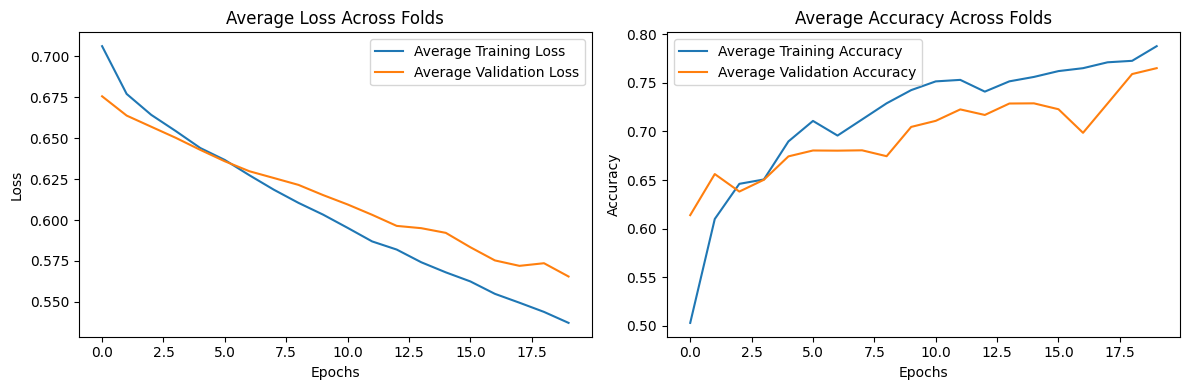

Mean val acc:  0.6967647126317025
Mean acc:  0.7150529730319978


In [ ]:
k = 5
epochs = 20
batch_size = 16
verbose = 0
stratified = True
b_m, b_hs, _ = perform_kfold(create_baseline_model,
         X_train, y_train,
         k=k,
         epochs=epochs,
         batch_size=batch_size,
         stratified=stratified
)
cd = collect_data(b_hs)
plot_acc_ls(cd["loss"],cd["acc"],cd["val_loss"], cd["val_acc"])
print("Mean val acc: ", cd["val_acc"].mean())
print("Mean acc: ", cd["acc"].mean())

In [ ]:
y_pred = b_m.predict(X_test).round()
labels = ["M", "R"]
bcm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)

2/2 [==============================] - 0s 9ms/step


In [18]:
b_m.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 40)                2440      
                                                                 
 dense_11 (Dense)            (None, 1)                 41        
                                                                 
Total params: 2481 (9.69 KB)
Trainable params: 2481 (9.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
def create_model():
  model = Sequential([
      Dense(10, activation="relu", kernel_regularizer=L2(0.03)),
      Dense(10, activation="relu", kernel_regularizer=L2(0.03)),
      #BatchNormalization(),
      Dropout(.3),
      Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy",
                optimizer=Adam(0.005),#0.003
                metrics=["acc"])
  return model

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def perform_PCA(X_train, X_test, n_components=None):
  if not n_components:
    n_components = int(0.9*X_train.shape[1])
  pca = PCA(n_components=n_components)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  transform_fn = lambda x: pca.transform(scaler.transform(x))
  return X_train, X_test, transform_fn

Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 4ms/step
Fold  1  acc:  0.7647058823529411
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 5ms/step
Fold  2  acc:  0.9090909090909091
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 6ms/step
Fold  3  acc:  0.7272727272727273
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 5ms/step
Fold  4  acc:  0.7575757575757576
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 6ms/step
Fold  5  acc:  0.9090909090909091


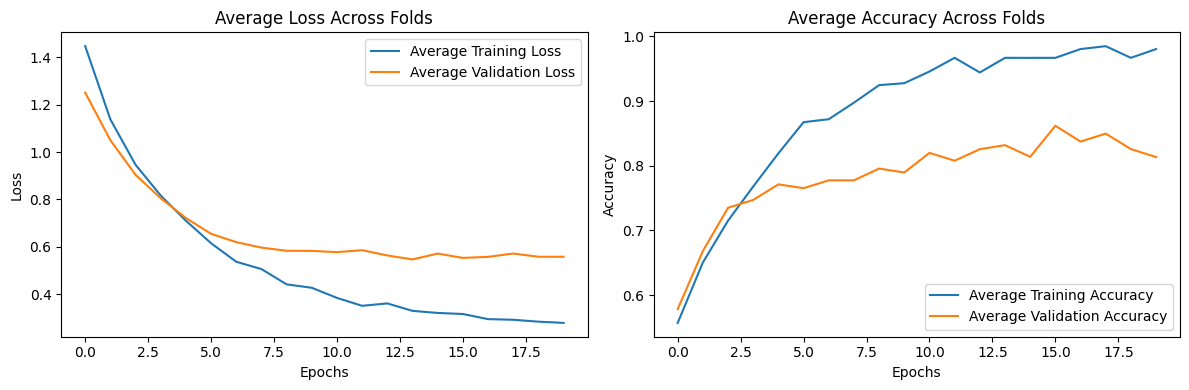

Mean val acc:  0.7846969798207283
Mean acc:  0.8834939655661582


In [22]:
k = 5
epochs = 20
batch_size = 8
verbose = False
callbacks = [
    #tf.keras.callbacks.ReduceLROnPlateau(patience=3),
]
stratified = True


m, hs, transform_fn = perform_kfold(create_model,
         X_train, y_train,
         k=k,
         epochs=epochs,
         batch_size=batch_size,
         stratified=stratified,
         callbacks=callbacks,
         preprocess_pipeline=[
             {perform_PCA: {"n_components": 40}} #40!!!!!!!!!
         ]
)
cd = collect_data(hs)
plot_acc_ls(cd["loss"],cd["acc"],cd["val_loss"], cd["val_acc"])
print("Mean val acc: ", cd["val_acc"].mean())
print("Mean acc: ", cd["acc"].mean())

Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 6ms/step
Fold  1  acc:  0.7941176470588235
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 6ms/step
Fold  2  acc:  0.8787878787878788
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 5ms/step
Fold  3  acc:  0.8484848484848485
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 4ms/step
Fold  4  acc:  0.7878787878787878
Done preprocess fn:  perform_PCA
2/2 [==============================] - 0s 7ms/step
Fold  5  acc:  0.8181818181818182


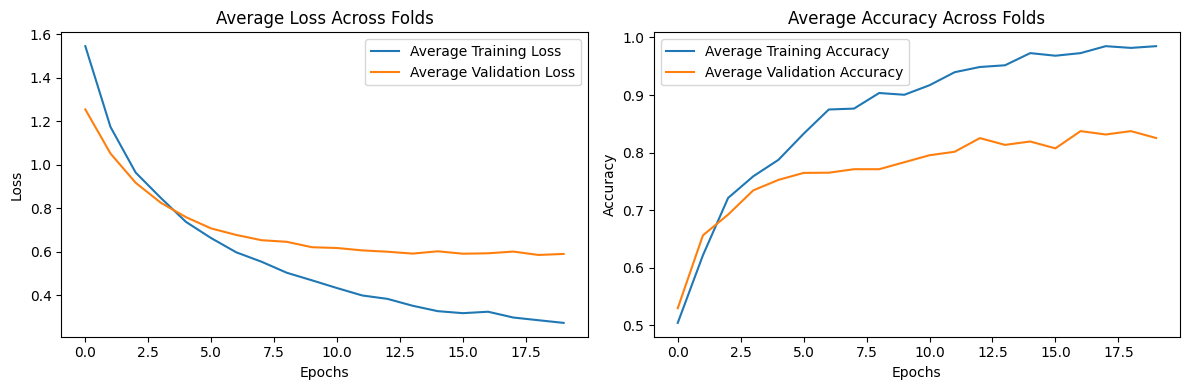

Mean val acc:  0.7708645296096801
Mean acc:  0.8703104388713836


In [ ]:
k = 5
epochs = 20
batch_size = 8
verbose = False
callbacks = [
    #tf.keras.callbacks.ReduceLROnPlateau(patience=3),
]
stratified = True


m, hs, transform_fn = perform_kfold(create_model,
         X_train, y_train,
         k=k,
         epochs=epochs,
         batch_size=batch_size,
         stratified=stratified,
         callbacks=callbacks,
         preprocess_pipeline=[
             {perform_PCA: {"n_components": 40}} #40!!!!!!!!!
         ]
)
cd = collect_data(hs)
plot_acc_ls(cd["loss"],cd["acc"],cd["val_loss"], cd["val_acc"])
print("Mean val acc: ", cd["val_acc"].mean())
print("Mean acc: ", cd["acc"].mean())

In [ ]:
m.evaluate(tfn(X_test), y_test)

2/2 [==============================] - 0s 8ms/step - loss: 1.9718 - acc: 0.3333


[1.9718073606491089, 0.3333333432674408]

In [ ]:
m.summary()

Model: "sequential_214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_563 (Dense)           (None, 10)                410       
                                                                 
 dense_564 (Dense)           (None, 10)                110       
                                                                 
 dropout_142 (Dropout)       (None, 10)                0         
                                                                 
 dense_565 (Dense)           (None, 1)                 11        
                                                                 
Total params: 531 (2.07 KB)
Trainable params: 531 (2.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tfn = transform_fn[0]

In [ ]:
y_pred = m.predict(tfn(X_test)).round()
labels = ["M", "R"]
mcm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
mcm

2/2 [==============================] - 0s 7ms/step
